<a href="https://colab.research.google.com/github/kushSins/Depression-Prediction-Model/blob/main/depressionpredection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk import ngrams
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import re
import string
import urllib.request
import requests
import bs4 as bs
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.decomposition import PCA,LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from textblob import TextBlob,Word

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def getlinks(soup):
    l = []
    for link in soup.find_all('a',class_ = "sfforumThreadTitle",href = True):
        l.append(link['href'][3:])
    return l

def getdate(soup):
  div = soup.find('div', class_ = 'sfforumPostAge')
  return(div.text.strip())
#
def getname(soup):
  div = soup.find('span', class_ = 'sfforumUser') 
  return(div.text)   
#
def getpost(soup):
    p = soup.find('div', class_ = 'postAndSig')
    return p.text.strip()
#
def getdf(site):
  sitelist = []
  string = '/page/'

  for i in range(2,36): 
      sitelist.append(site + string + str(i))

  dftoappend = pd.DataFrame()
  df = pd.DataFrame()

  for sites in sitelist:
      print(sites)
      sauce = urllib.request.urlopen(sites)
      soup = bs.BeautifulSoup(sauce,'html.parser')
      links = getlinks(soup)
      for link in links:
          sauce = urllib.request.urlopen(site + '/' + link)
          soup = bs.BeautifulSoup(sauce,'html.parser')
          date = getdate(soup)
          name = getname(soup)
          post = getpost(soup)
          d = [{'DATE' : date, 'NAME' : name, 'TEXT' : post}]
          dftoappend = pd.DataFrame(d)
          df = df.append(dftoappend,ignore_index = True)
  return df

In [ ]:
site1 = 'https://www.beyondblue.org.au/get-support/online-forums/depression'
site2 = 'https://www.beyondblue.org.au/get-support/online-forums/staying-well'

df1 = getdf(site1) 
df1 = df1.set_index("NAME")
df1.to_csv('dep.csv')
df2 = getdf(site2) 
df2 = df2.set_index("NAME")
df2.to_csv('nor.csv')

In [ ]:
english = pd.read_csv('dep.csv')
english['DEPRESSED'] = 1
english.head()

,NAME,DATE,TEXT,DEPRESSED
0,Cereal,22 February 2022,I looked up what to do when you think everybod...,1
1,nib,5 September 2021,I am not sure what to do at this point?\nMy mo...,1
2,Alannah57,21 February 2022,Does anyone else find their mixed episodes sta...,1
3,Leigh1987,18 September 2020,"Hi all, \r\n\nI went to the gp again last nigh...",1
4,WantOut,20 February 2022,I need to function much better than I am; I ha...,1


In [ ]:
normal = pd.read_csv('nor.csv')
normal['DEPRESSED'] = 0
normal.head()

,NAME,DATE,TEXT,DEPRESSED
0,white knight,5 January 2017,"Financial ""stress"" is a hollow feeling. Just a...",0
1,white knight,14 January 2022,"We humans are accustomed to certain ""givens"". ...",0
2,white knight,22 January 2022,Some years ago I wrote a post - When all is lo...,0
3,white knight,22 January 2022,This time of year seems to raise the topic of ...,0
4,Apollonia,4 December 2021,I have come a long way since struggling anxiet...,0


In [ ]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len([words]))

def pipeline(train1, whatstop):
    train1['LINE_NUM'] = train1['TEXT'].apply(lambda x: str(x).count('\n') - 2)
    train1['WORD_COUNT'] = train1['TEXT'].apply(lambda x: len(str(x).split(" ")))
    train1['CHAR_COUNT'] = train1['TEXT'].str.len() ## this also includes spaces
    train1['TEXT'] = train1['TEXT'].apply(lambda x: re.sub(r'\n',' ',x))
    train1['TEXT'] = train1['TEXT'].str.replace(r'\s+',' ')
    train1['TAG'] = train1['TEXT'].str.contains('@')
    train1['STOPWORDS'] = train1['TEXT'].apply(lambda x: len([x for x in str(x).split() if x in whatstop]))
    train1['HASHTAGS'] = train1['TEXT'].apply(lambda x: len([x for x in str(x).split() if x.startswith('#')]))
    train1['UPPER'] = train1['TEXT'].apply(lambda x: len([x for x in str(x).split() if x.isupper()]))
    train1['NUMERICS'] = train1['TEXT'].apply(lambda x: len([x for x in str(x).split() if x.isdigit()]))
    #train1['AVG_WORDS_LEN'] = train1['TEXT'].apply(lambda x: avg_word(str(x)))
    train1['AVG_WORDS_LEN'] = train1['CHAR_COUNT'] / train1['WORD_COUNT'] # including spaces
    #lexical divercity
    train1['LEXICAL_DIVER'] = train1['TEXT'].apply(lambda x: len(x) / len(set(x)))
    return train1

In [ ]:
additional_stopwords = "you that him to it her there etc know want one hey hi yep well really hello a like don't about above after again against all am an and any are aren't as at be because been before being below between both but by can't cannot could couldn't did didn't do does doesn't doing don't down during each few for from further had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm i've if in into is isn't it it's its itself let's me more most mustn't my myself no nor not of off on once only or other oughtour ours ourselves out over own same shan't she she'd she'll she's should shouldn't so some such than that that's the their theirs them themselves then there there's these they they'd they'll they're they've this those through to too under until up very was wasn't we we'd we'll we're we've were weren't what what's when when's where where's which while who who's whom why why's with won't would wouldn't you you'd you'll you're you've your yours yourself yourselves"
removing_words = 'beyondblue beyond blue tony wk tony geoff neil depression'
englishstop = stopwords.words("english")
englishstop += additional_stopwords.split()
englishstop += removing_words.split()
nopunc = re.sub("'",'',additional_stopwords)
englishstop += nopunc.split()
englishstop = set(englishstop)

In [ ]:
#getting the basic feature extraction from the depressed and undepressed posts
english = pipeline(english,englishstop)
normal = pipeline(normal,englishstop)
english.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


,NAME,DATE,TEXT,DEPRESSED,LINE_NUM,WORD_COUNT,CHAR_COUNT,TAG,STOPWORDS,HASHTAGS,UPPER,NUMERICS,AVG_WORDS_LEN,LEXICAL_DIVER
0,Cereal,22 February 2022,I looked up what to do when you think everybod...,1,-2,232,1067,False,88,0,18,1,4.599138,28.861111
1,nib,5 September 2021,I am not sure what to do at this point? My mot...,1,0,414,2250,False,204,0,21,0,5.434783,54.853659
2,Alannah57,21 February 2022,Does anyone else find their mixed episodes sta...,1,-1,42,253,False,17,0,0,0,6.023810,8.433333
3,Leigh1987,18 September 2020,"Hi all, I went to the gp again last night look...",1,4,120,630,False,58,0,4,0,5.250000,18.878788
4,WantOut,20 February 2022,I need to function much better than I am; I ha...,1,11,362,1980,False,171,0,19,0,5.469613,43.688889


In [ ]:
english.describe()

,DEPRESSED,LINE_NUM,WORD_COUNT,CHAR_COUNT,STOPWORDS,HASHTAGS,UPPER,NUMERICS,AVG_WORDS_LEN,LEXICAL_DIVER
count,1697.0,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000
mean,1.0,2.625810,231.152033,1212.946376,106.742487,0.000589,13.350029,1.170890,5.266251,29.539903
std,0.0,6.157781,138.054074,726.746523,65.229396,0.024275,10.906498,1.661233,0.501097,14.982766
min,1.0,-2.000000,1.000000,11.000000,0.000000,0.000000,0.000000,0.000000,3.296012,1.100000
25%,1.0,-2.000000,118.000000,620.000000,53.000000,0.000000,5.000000,0.000000,5.038934,17.615385
50%,1.0,1.000000,208.000000,1086.000000,94.000000,0.000000,11.000000,1.000000,5.215625,28.114286
75%,1.0,4.000000,336.000000,1775.000000,156.000000,0.000000,20.000000,2.000000,5.420168,41.439024
max,1.0,64.000000,783.000000,4693.000000,374.000000,1.000000,157.000000,11.000000,15.000000,92.380000


In [ ]:
english.corr()

,DEPRESSED,LINE_NUM,WORD_COUNT,CHAR_COUNT,TAG,STOPWORDS,HASHTAGS,UPPER,NUMERICS,AVG_WORDS_LEN,LEXICAL_DIVER
DEPRESSED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LINE_NUM,NaN,1.000000,0.416555,0.460322,-0.015672,0.405532,-0.014302,0.313181,0.157962,0.234344,0.395450
WORD_COUNT,NaN,0.416555,1.000000,0.993653,0.044472,0.979722,0.037800,0.721206,0.399549,-0.063037,0.962715
CHAR_COUNT,NaN,0.460322,0.993653,1.000000,0.045241,0.971520,0.042849,0.708901,0.390435,0.001261,0.961368
TAG,NaN,-0.015672,0.044472,0.045241,1.000000,0.022323,-0.001022,0.047538,0.012563,0.001320,0.019053
STOPWORDS,NaN,0.405532,0.979722,0.971520,0.022323,1.000000,0.025045,0.666269,0.373302,-0.081434,0.960349
HASHTAGS,NaN,-0.014302,0.037800,0.042849,-0.001022,0.025045,1.000000,0.017037,0.070608,0.015895,0.024310
UPPER,NaN,0.313181,0.721206,0.708901,0.047538,0.666269,0.017037,1.000000,0.261402,-0.108249,0.692368
NUMERICS,NaN,0.157962,0.399549,0.390435,0.012563,0.373302,0.070608,0.261402,1.000000,-0.060251,0.313132
AVG_WORDS_LEN,NaN,0.234344,-0.063037,0.001261,0.001320,-0.081434,0.015895,-0.108249,-0.060251,1.000000,-0.046550


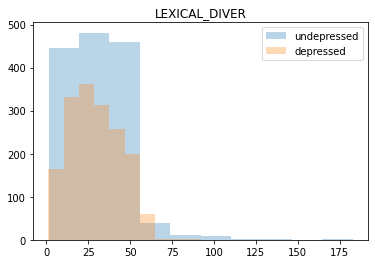

In [ ]:
plt.hist(normal['LEXICAL_DIVER'],label = 'undepressed',alpha = 0.3)
plt.hist(english['LEXICAL_DIVER'],label = 'depressed',alpha = 0.3)
plt.title('LEXICAL_DIVER')
plt.legend()
plt.show()

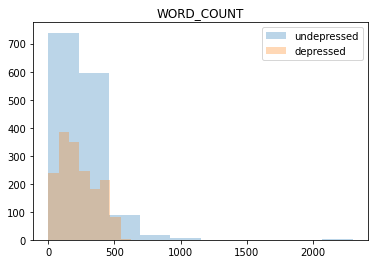

In [ ]:
plt.hist(normal['WORD_COUNT'],label = 'undepressed',alpha = 0.3)
plt.hist(english['WORD_COUNT'],label = 'depressed',alpha = 0.3)
plt.title('WORD_COUNT')
plt.legend()
plt.show()

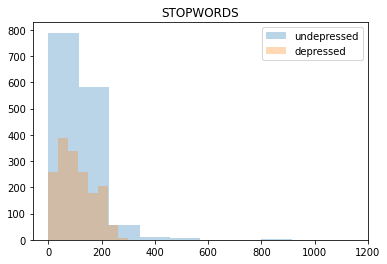

In [ ]:
plt.hist(normal['STOPWORDS'],label = 'undepressed',alpha = 0.3)
plt.hist(english['STOPWORDS'],label = 'depressed',alpha = 0.3)
plt.title('STOPWORDS')
plt.legend()
plt.show()

cleaning the data

In [ ]:
def cleanpipe(train1,whatstop):
    train1['DATE'] = train1['DATE'].str.replace('[\n\t\t\t]','')
    train1['DATE'] = train1['DATE'].str.strip()
    train1['WORKING_TEXT'] = train1['TEXT'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].str.replace(r'\d+',' ')
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].str.replace(r'[^\w\s]',' ')
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].str.replace(r'\s+',' ')
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x:" ".join(x for x in x.split() if (x not in whatstop)))
   
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x: " ".join(x for x in x.split() if not(x.startswith('www'))))
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x: " ".join(x for x in x.split() if not(x.startswith('http'))))                
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x: " ".join(x for x in x.split() if not(len(x)< 2)))                

    
    train1.drop(train1[train1['WORD_COUNT'] < 8].index,inplace = True)
    
  
    
    train1 = train1.drop_duplicates(subset = 'WORKING_TEXT')
    return train1


##remove freq word function
def freqremovel(train1, freq):
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x: " ".join(x for x in x.split() if x in freq))
    return train1

In [ ]:
newenglish = cleanpipe(english,englishstop)
newnormal = cleanpipe(normal,englishstop)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [ ]:
newenglish.head()

,NAME,DATE,TEXT,DEPRESSED,LINE_NUM,WORD_COUNT,CHAR_COUNT,TAG,STOPWORDS,HASHTAGS,UPPER,NUMERICS,AVG_WORDS_LEN,LEXICAL_DIVER,WORKING_TEXT
0,Cereal,22 February 2022,I looked up what to do when you think everybod...,1,-2,232,1067,False,88,0,18,1,4.599138,28.861111,looked think everybody hates morning thing ans...
1,nib,5 September 2021,I am not sure what to do at this point? My mot...,1,0,414,2250,False,204,0,21,0,5.434783,54.853659,sure point mother drinks gambles excessively s...
2,Alannah57,21 February 2022,Does anyone else find their mixed episodes sta...,1,-1,42,253,False,17,0,0,0,6.023810,8.433333,anyone else find mixed episodes start feelings...
3,Leigh1987,18 September 2020,"Hi all, I went to the gp again last night look...",1,4,120,630,False,58,0,4,0,5.250000,18.878788,went gp last night looking relief constant cru...
4,WantOut,20 February 2022,I need to function much better than I am; I ha...,1,11,362,1980,False,171,0,19,0,5.469613,43.688889,need function much better children need earn m...


In [ ]:
englishfreq = pd.Series(' '.join(newenglish['WORKING_TEXT']).split()).value_counts()[220:-600]
newenglish = freqremovel(newenglish,englishfreq)

normal_freq = pd.Series(' '.join(newnormal['WORKING_TEXT']).split()).value_counts()[150:-200]
newnormal = freqremovel(newnormal,normal_freq)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


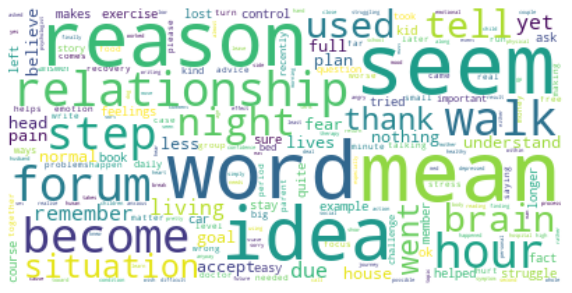

In [ ]:
def PostWordCloud(df):
    string = ''
    for line in df['WORKING_TEXT']:
        string = string + str(line)
    
    wordcloud = WordCloud(background_color='white',max_font_size=60).generate(string)
    plt.figure(figsize=(10,10))
    
    #plot wordcloud in matplotlib
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
PostWordCloud(newnormal)

## Advenced Text Processing

### n-grams

In [ ]:
def getstring(df):
    string = ''
    for line in df['TEXT']:
        string = string + str(line)
    return(string)

def getngrams(strings, n):
    ngram_counts = Counter(ngrams(strings.split(),n))
    ngram_counts = ngram_counts.most_common()
    n_grams_freq = pd.DataFrame(ngram_counts)
    n_grams_freq['string'] = n_grams_freq[0].apply(lambda x:','.join(x))
    return n_grams_freq

In [ ]:
strings = getstring(newenglish)
n2gramenglish = getngrams(strings,2)
n2gramenglish.head()

,0,1,string
0,"(I, have)",2360,"I,have"
1,"(I, am)",1762,"I,am"
2,"(and, I)",1469,"and,I"
3,"(I, feel)",1281,"I,feel"
4,"(I, was)",1167,"I,was"


In [ ]:
def getdict(adjCorpus):
    wordSet = set()
    newdf = pd.DataFrame()
    for word in adjCorpus['WORKING_TEXT']:
        words = (TextBlob(str(word)).words)
        words = list(words)
        wordSet.update(words)
        
    return wordSet


def getPOStags(mydict):
    pos_tags = nltk.pos_tag(mydict)
    pos_tags_df = pd.DataFrame(pos_tags,columns = ['words','POS'])
    countPOS = pos_tags_df.groupby('POS').count()
    return pos_tags_df,countPOS

In [ ]:
englishdict = getdict(newenglish) # 1006 #920 # 917
# getting POS tags and count
english_POS,english_POS_count = getPOStags(englishdict)

normal_posts_dict = getdict(newnormal) # 1006 #920 # 917
# getting POS tags and count
normal_POS,normal_POS_count = getPOStags(normal_posts_dict)

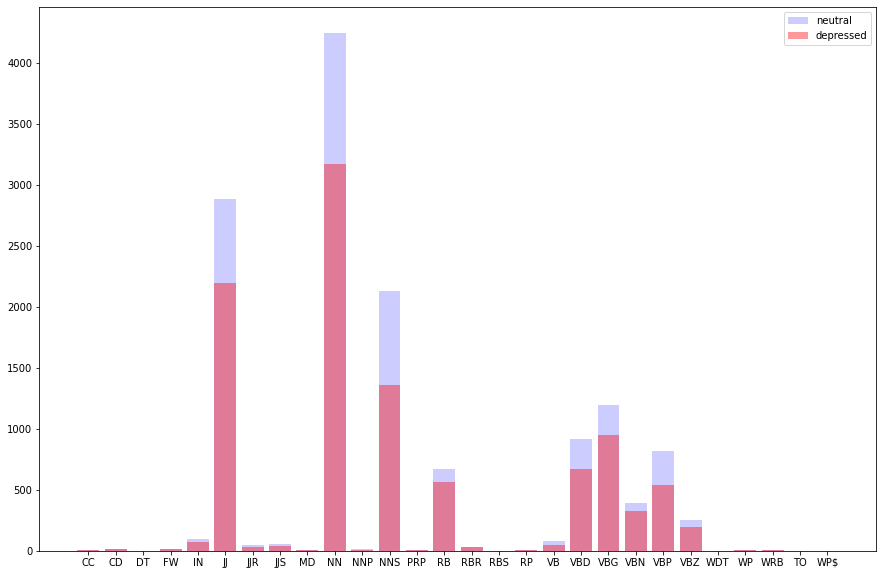

In [ ]:
plt.figure(figsize=(15,10))
plt.bar(normal_POS_count.index,normal_POS_count['words'],color = 'blue',alpha = 0.2,label = 'neutral')
plt.bar(english_POS_count.index,english_POS_count['words'],color = 'red',alpha = 0.4,label = 'depressed')
plt.legend()
plt.show()

## sentiment analysis




In [ ]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

[]

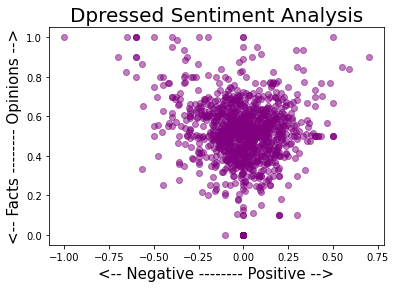

In [ ]:
newenglish['polarity'] = newenglish['WORKING_TEXT'].apply(pol)
newenglish['subjectivity'] = newenglish['WORKING_TEXT'].apply(sub)
plt.scatter(newenglish['polarity'][:1100],newenglish['subjectivity'][:1100], c = 'purple',alpha = 0.5)
plt.title('Dpressed Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)
plt.plot()

[]

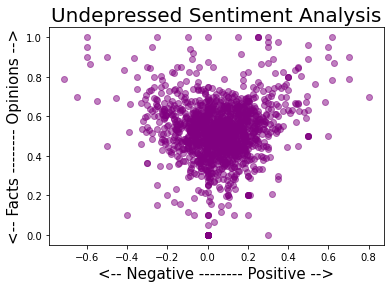

In [ ]:
newnormal['polarity'] = newnormal['WORKING_TEXT'].apply(pol)
newnormal['subjectivity'] = newnormal['WORKING_TEXT'].apply(sub)
plt.scatter(newnormal['polarity'],newnormal['subjectivity'], c = 'purple',alpha = 0.5)
plt.title('Undepressed Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)
plt.plot()

In [ ]:
newenglish[:1100][newenglish['polarity'] > 0.25].count() # 71             #POSITIVE
newnormal[newnormal['polarity'] > 0.25].count() #110
newenglish[:1100][newenglish['subjectivity'] > 0.6].count() #279           #OPINION
newnormal[newnormal['subjectivity'] > 0.6].count() #274
##
newenglish[:1100][newenglish['polarity'] < -0.25].count() # 115              #NEGATIVE
newnormal[newnormal['polarity'] < -0.25].count() # 56
newenglish[:1100][newenglish['subjectivity'] < 0.4].count() #255          #FACT
newnormal[newnormal['subjectivity'] < 0.4].count() #256

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


NAME             241
DATE             241
TEXT             241
DEPRESSED        241
LINE_NUM         241
WORD_COUNT       241
CHAR_COUNT       241
TAG              241
STOPWORDS        241
HASHTAGS         241
UPPER            241
NUMERICS         241
AVG_WORDS_LEN    241
LEXICAL_DIVER    241
WORKING_TEXT     241
polarity         241
subjectivity     241
dtype: int64

In [ ]:

bow = CountVectorizer()
A = bow.fit_transform(newenglish['WORKING_TEXT'])

In [ ]:
search_params = {'n_components': [3,4,5],'learning_decay': [.7,.9]}
lda = LatentDirichletAllocation()


model = GridSearchCV(lda, param_grid = search_params)
model.fit(A)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.7, 0.9],
                         'n_components': [3, 4, 5]})

In [ ]:
best_lda_model = model.best_estimator_
W = best_lda_model.fit_transform(A)
H = best_lda_model.components_

In [ ]:

topicnames = ["Topic" + str(i) for i in range(1,4)]


docnames = ["Doc" + str(i) for i in range(0,len(newenglish))]


df_document_topic = pd.DataFrame(np.round(W,2), columns=topicnames, index=docnames)


dominant_topic = np.argmax(df_document_topic.values, axis=1)

In [ ]:
df_document_topic = pd.DataFrame(W)
df_document_topic_array = np.array(W)
dominant_topic = np.argmax(df_document_topic_array, axis=1)

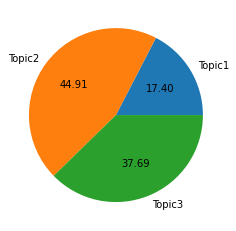

In [ ]:
topics = pd.DataFrame(dominant_topic)
topics.reset_index(inplace = True)

count = topics.groupby(0).count()
count = count['index']
plt.pie(count,labels = ['Topic1','Topic2','Topic3'],autopct ='%.2f')
plt.show()

In [ ]:
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
terms = bow.get_feature_names()

for topic_index in range(3):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: sorry, lately, may, illness, face, matter, cry, meds, study, career
Topic 02: mood, idea, moved, kind, become, decided, together, cause, crying, happened
Topic 03: son, emotions, child, children, age, reading, finding, experience, real, currently


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df = pd.DataFrame(descriptors)
df = df.transpose()
df.columns = ['Topic1','Topic2','Topic3']
df

,Topic1,Topic2,Topic3
0,sorry,mood,son
1,lately,idea,emotions
2,may,moved,child
3,illness,kind,children
4,face,become,age
5,matter,decided,reading
6,cry,together,finding
7,meds,cause,experience
8,study,crying,real
9,career,happened,currently


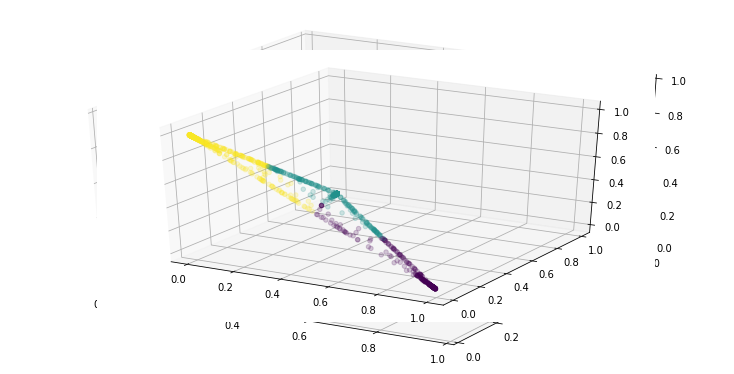

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)  
ax = fig.add_subplot(111, projection='3d',)
ax.scatter(df_document_topic[0],df_document_topic[1],df_document_topic[2],c = dominant_topic,alpha = 0.2)
plt.show()

# showing differently with pca

In [ ]:
bow = TfidfVectorizer(max_features=1000000, lowercase=True, ngram_range=(1,1),analyzer = "word")

train_data_features = bow.fit_transform(newenglish['WORKING_TEXT'])

svd = TruncatedSVD(n_components=3) 

data = svd.fit_transform(train_data_features) #vectors = pd.DataFrame(train_data_features)

englishdata = pd.DataFrame(data,columns = ['xlabel','ylabel','zlabel'])

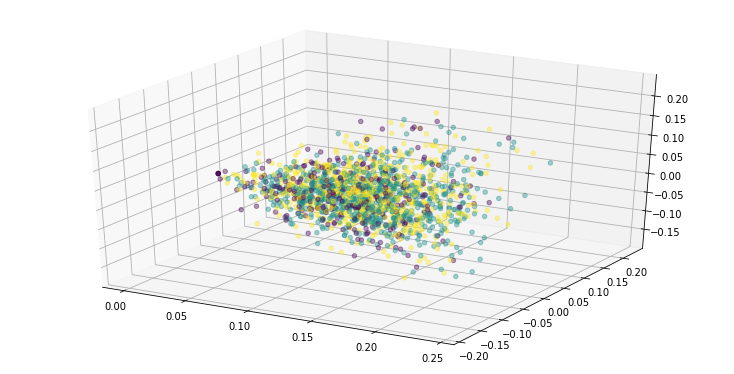

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)                                                                 
ax.scatter(englishdata.xlabel,englishdata.ylabel,englishdata.zlabel,c=dominant_topic,alpha = 0.4)
plt.show()

# building a predictor

In [ ]:
newenglish2 = newenglish.append(newnormal,ignore_index = True)

In [ ]:
bow = CountVectorizer()

A = bow.fit_transform(newenglish2['WORKING_TEXT'])

In [ ]:

clfs = [SVC(kernel='rbf',C=40),MultinomialNB(),KNeighborsClassifier(n_neighbors=7)]
for clf in clfs:
    scores = cross_validate(clf,A, newenglish2['DEPRESSED'],cv=10)
    print(np.mean(scores["test_score"]))

0.9097464439063104
0.9626889969679086
0.5623593333468997


In [ ]:
XTrain, XTest, yTrain, yTest = train_test_split(A, newenglish2['DEPRESSED'], random_state=1, test_size=0.2)

model = MultinomialNB()
model.fit(XTrain,yTrain)
yPred = model.predict(XTest)

print('model score and confusion matrix')
print(model.score(XTest,yTest))
print(confusion_matrix(yTest, yPred))

model score and confusion matrix
0.9537480063795853
[[274  12]
 [ 17 324]]
